In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_log_error

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from tensorflow.random import set_seed
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

set_seed(455)
np.random.seed(455)

In [5]:
dataset = pd.read_csv('data/bitcoin/bitcoin_preprocessed.csv', parse_dates=['Date'], index_col = "Date")

In [20]:
dataset

,Close,Open,High,Low,Volume,Change %,Average
Date,,,,,,,
2010-07-18,0.1,0.0,0.1,0.1,80.0,0.00%,0.10
2010-07-19,0.1,0.1,0.1,0.1,570.0,0.00%,0.10
2010-07-20,0.1,0.1,0.1,0.1,260.0,0.00%,0.10
2010-07-21,0.1,0.1,0.1,0.1,580.0,0.00%,0.10
2010-07-22,0.1,0.1,0.1,0.1,2160.0,0.00%,0.10
...,...,...,...,...,...,...,...
2024-12-28,95284.5,94274.9,95684.3,94124.7,32970.0,1.07%,94904.50
2024-12-29,93716.3,95282.6,95315.4,93026.7,47710.0,-1.65%,94171.05
2024-12-30,92779.8,93718.7,94936.4,91522.3,112430.0,-1.00%,93229.35


In [21]:
def evaluate_model(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    mae = mean_absolute_error(test, predicted)
    r2 = r2_score(test, predicted)
    msle = mean_squared_log_error(test, predicted)
    mape = np.mean(np.abs((test - predicted) / test)) * 100

    print(f"The root mean squared error (RMSE) is {rmse:.2f}")
    print(f"The Mean Absolute Error (MAE) is {mae:.2f}")
    print(f"The R-squared (R²) score is {r2:.4f}\n")
    print(f"The Mean Squared Logarithmic Error (MSLE) is {msle:.6f}")
    print(f"The Mean Absolute Percentage Error (MAPE) is {mape:.2f}%.")

In [35]:
def plot_predictions(test, predicted):
    plt.figure(figsize=(16, 9))
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Bitcoin Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Bitcoin Price ($)")
    plt.legend()
    plt.show()

In [22]:
# train-test
tstart = "2010-07-18"
tend = "2024-01-10"

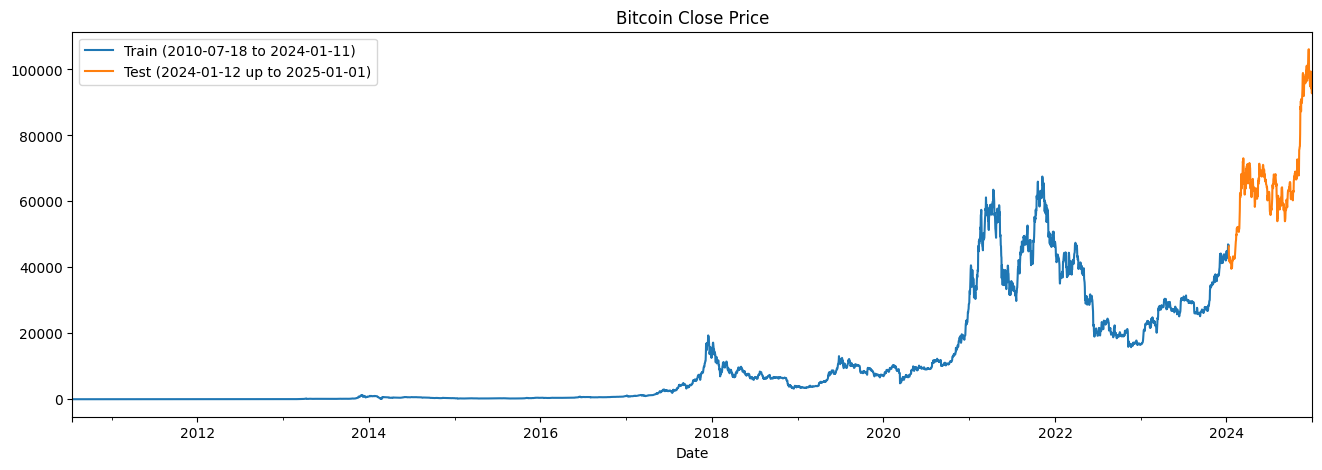

In [23]:
def train_test_plot(dataset, tstart, tend):
    tend_next = pd.to_datetime(tend) + pd.Timedelta(days=1)

    dataset.loc[tstart:tend, "Close"].plot(figsize=(16, 5), legend=True)
    dataset.loc[tend_next:, "Close"].plot(figsize=(16, 5), legend=True)

    plt.legend([f"Train (2010-07-18 to {tend_next.date()})", f"Test ({tend_next.date() + pd.Timedelta(days=1)} up to 2025-01-01)"])
    plt.title("Bitcoin Close Price")
    plt.show()

train_test_plot(dataset, tstart, tend)

In [24]:
def train_test_split(dataset, tstart, tend):
    tend_next = pd.to_datetime(tend) + pd.Timedelta(days=1)

    train = dataset.loc[tstart:tend, "Close"].values
    test = dataset.loc[tend_next:, "Close"].values
    return train, test

training_set, test_set = train_test_split(dataset, tstart, tend)

In [25]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [26]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [27]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

In [13]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(units=125, activation="tanh", input_shape=(n_steps, features))))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
# 10 min
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 22s 117ms/step - loss: 0.0086
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - loss: 6.9692e-04
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - loss: 5.1356e-04
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - loss: 4.6489e-04
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - loss: 3.8490e-04
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - loss: 3.4002e-04
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - loss: 3.0297e-04
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - loss: 2.7604e-04
Epoch 9/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - loss: 2.6240e-04
Epoch 10/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 23s 131ms/step - loss: 2.5072e-04
Epoch 11/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 116ms/step - loss: 2.3558e-04
Epoch 12/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 17s 114ms/step - loss: 2.1925e-04
Epoch 13/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 22s 121ms/step - loss: 2.1022e-04
Epoch 14/50
153/153 ━━━━━━━━━━━━━━━━━━

In [16]:
def plot_predictions(test, predicted):
    plt.figure(figsize=(16, 9))
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Bitcoin Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Bitcoin Price ($)")
    plt.legend()
    plt.show()

In [30]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 125)               48000     
                                                                 
 dense_2 (Dense)             (None, 1)                 126       
                                                                 
Total params: 48,126
Trainable params: 48,126
Non-trainable params: 0
_________________________________________________________________


In [31]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

In [32]:
# 10 min
model_gru.fit(X_train, y_train, epochs=100, batch_size=64, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
77/77 [==============================] - 5s 42ms/step - loss: 0.0029 - lr: 0.0010
Epoch 2/100
77/77 [==============================] - 4s 47ms/step - loss: 4.2989e-04 - lr: 0.0010
Epoch 3/100
77/77 [==============================] - 4s 48ms/step - loss: 4.1095e-04 - lr: 0.0010
Epoch 4/100
77/77 [==============================] - 4s 46ms/step - loss: 4.5284e-04 - lr: 0.0010
Epoch 5/100
77/77 [==============================] - 4s 48ms/step - loss: 3.5079e-04 - lr: 0.0010
Epoch 6/100
77/77 [==============================] - 4s 48ms/step - loss: 3.1159e-04 - lr: 0.0010
Epoch 7/100
77/77 [==============================] - 4s 48ms/step - loss: 3.0040e-04 - lr: 0.0010
Epoch 8/100
77/77 [==============================] - 4s 49ms/step - loss: 2.6481e-04 - lr: 0.0010
Epoch 9/100
77/77 [==============================] - 4s 54ms/step - loss: 2.5513e-04 - lr: 0.0010
Epoch 10/100
77/77 [==============================] - 5s 70ms/step - loss: 2.4670e-04 - lr: 0.0010
Epoch 11/100
77/77 [===

In [33]:
dataset_total = dataset.loc[:, "Close"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_gru.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

12/12 [==============================] - 0s 7ms/step


12/12 [==============================] - 0s 11ms/step


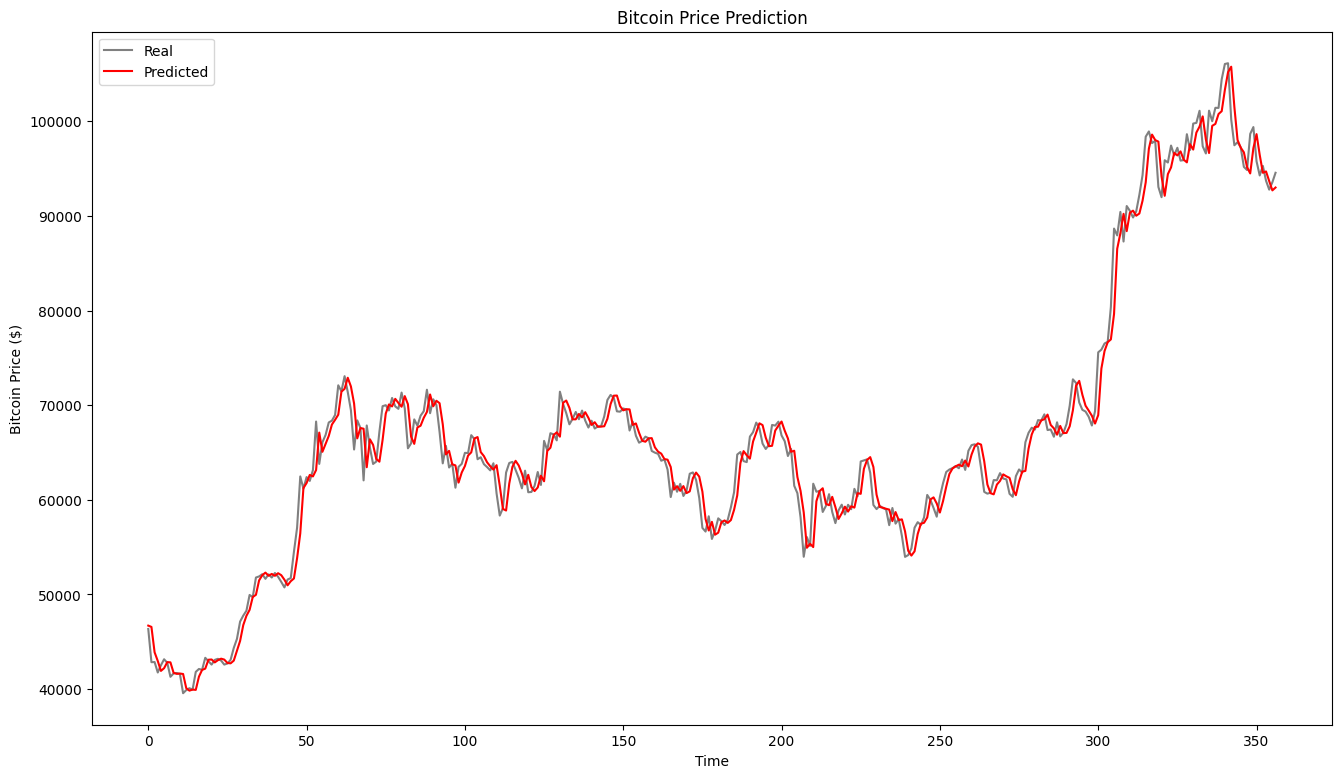

In [36]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)

In [37]:
evaluate_model(test_set, predicted_stock_price)

The root mean squared error (RMSE) is 1903.58
The Mean Absolute Error (MAE) is 1366.47
The R-squared (R²) score is 0.9827

The Mean Squared Logarithmic Error (MSLE) is 0.000796
The Mean Absolute Percentage Error (MAPE) is 23.06%.


### Short Comparison

We can compare these two charts and conclude that the **GRU** model is more accurate in predicting latest (higher) prices and ramps up the lower prices at the earlier periods (especially where Time between 200 and 600). The RMSE here is still less, probably because the higher prices have smaller residuals, overshadowing poorer performance earlier (in Time).

On the other hand, **LSTM** is more precise in predicting earlier price movements (compare Time between 200 and 600), whereas it is less robust in identifying the most recent trends.

To improve models & RMSE:
- increase `batch_size`
- increase or decrease `n_steps` in **split_sequence**
- train more epochs
- improve model structure (especially GRU)
- reducing dataset (e.g. start from 2017)
- separate normalization over different time windows
- extend `train_set` (e.g. to 0.85)
- try various activation functions

# Exponential Moving Average Experimentation (wrong)

In [13]:
def exponential_moving_average(data, alpha=None, window=None):
    if len(data) < 2:
        raise ValueError("Data must contain at least two elements.")

    if window and alpha is None:
        alpha = 2 / (window + 1)  # Convert window size to alpha

    if alpha is None or not (0 < alpha <= 1):
        raise ValueError("Alpha must be between 0 and 1.")

    ema = [data[0]]  # Initialize with first data point
    
    for i in range(1, len(data)):
        ema.append(alpha * data[i] + (1 - alpha) * ema[-1])  # Apply EMA formula

    return ema


In [30]:
def plot_ema(years, data, ema_values, title="Exponential Moving Average (EMA) Visualization"):
    if len(years) != len(data) or len(data) != len(ema_values):
        raise ValueError("Years, data, and EMA values must have the same length.")

    plt.figure(figsize=(16, 9))
    
    # Original data line (solid blue)
    plt.plot(years, data, linestyle='-', color='blue', label="Original Data")
    
    # EMA line (dashed red)
    plt.plot(years, ema_values, linestyle='--', color='red', label="EMA")
    
    # Labels and title
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    
    # Grid for better visualization
    plt.grid(True)
    
    # Show plot
    plt.show()

In [34]:
def calculate_mae(data, ema_values):
    if len(data) != len(ema_values):
        raise ValueError("Data and EMA values must have the same length.")

    mae = np.mean(np.abs(np.array(data) - np.array(ema_values)))
    return mae

The Mean Absolute Error (MAE) is 676.5053


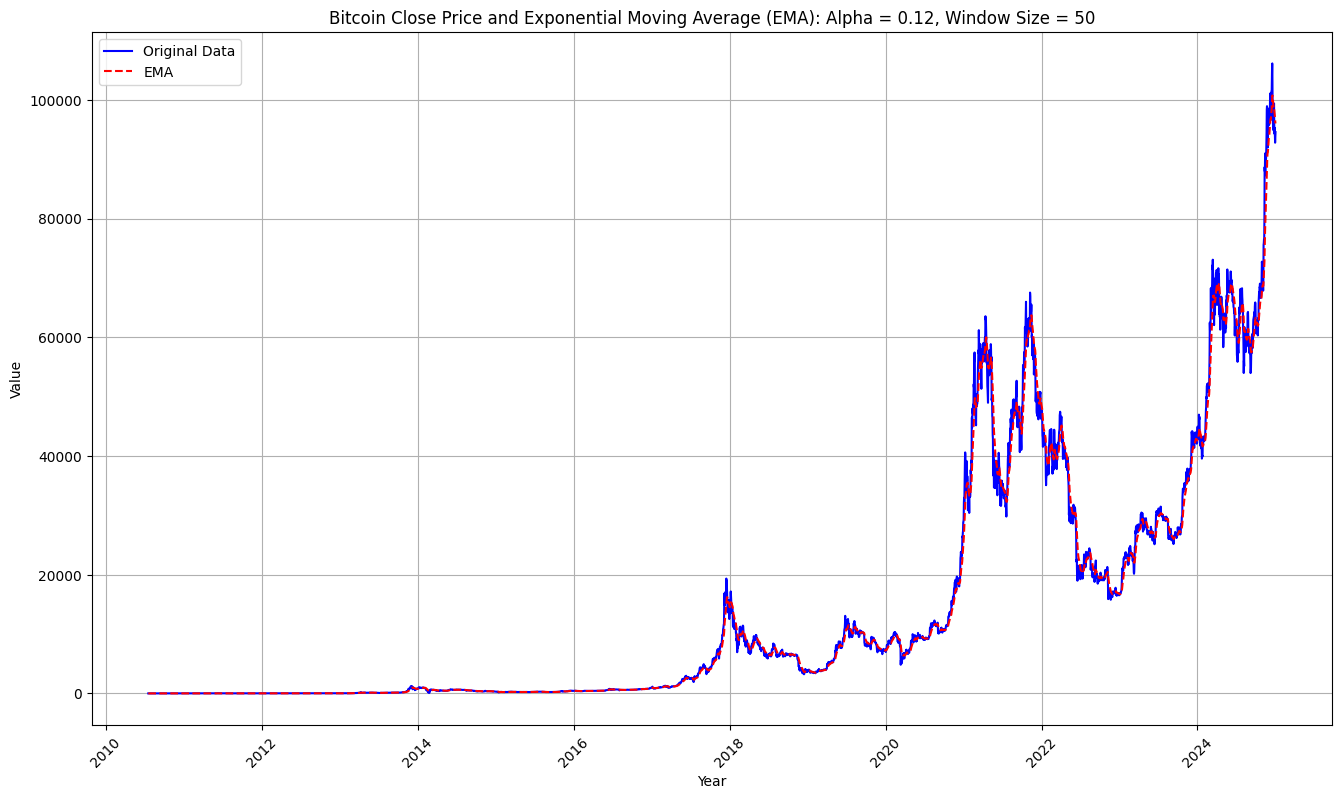

In [48]:
data_series = dataset["Close"].values
window_size = 100
alpha = 0.12
ema_values = exponential_moving_average(data_series, alpha=alpha, window=window_size)
mae = calculate_mae(data_series, ema_values)
print(f"The Mean Absolute Error (MAE) is {mae:.4f}")
plot_ema(dataset.index, data_series, ema_values, title=f"Bitcoin Close Price and Exponential Moving Average (EMA): Alpha = {alpha}, Window Size = 50")